In [70]:
library(pracma)
library(plotly)
library(matrixcalc)
#load source file
src.path <- "../src"
source(paste(src.path, "DataGenerationProcess", "synth_basis.R", sep="/"))
source(paste(src.path, "DataGenerationProcess", "synth_data.R", sep="/"))
source(paste(src.path, "DataGenerationProcess", "synth_graph.R", sep="/"))
source(paste(src.path, "DataGenerationProcess", "synth_linearop.R", sep="/"))

source(paste(src.path, "Estimation", "basis_estimation.R", sep="/"))
source(paste(src.path, "Utility", "utility.R", sep="/"))

source(paste(src.path, "Estimation", "cca_estimation.R", sep="/"))
library(viridis)
library(fields)

In [71]:
cross.cov <- function(obj1,obj2, basis1, basis2, lambda1, lambda2, ncan=NULL){
    ###################
    # obj1: functional object1
    # obj2: functional object1
    # basis1: funcational basis object 1
    # basis2: functional basis object 2
    ###################
    

    score1 <- inprod(obj1, basis1)
    n <- dim(score1)[1]
    #inv_score1 <-  diag(1 / sqrt(lambda1))
    score1 <- score1# %*% inv_score1

    score2 <- inprod(obj2, basis2)
    #inv_score2 <- diag(1 / sqrt(lambda2))
    score2 <- score2 #%*% inv_score2

    D.matrix <- (t(score1) %*% score2)/n
    return(D.matrix)

}

In [75]:
#remember to set the cca value to be dependent data, the results quite differ a lot


n <- 100 #vary this to see the outcomes
p <- 50
k.gen <- 11
M <- 2
obs.time <- seq(0,1,1/50)
## be careful for the choice of the number of basis function 
## fourier basis: km must be odd
## bspline basis km>4
km.gen <- c(11, 11)
##data generation process 1##
# generate latent covariance matrix
cov <- solve(synth.omega.tridiag2(p, k.gen))
# generate Amatrix, Noisematrix, basis matrix
Apinv_list <- list()
A_list <- list()
N_list <- list()
basis.m_list <- list()
true.basis_list <- list()
true.values_list <- list()


for(m in 1:M){
    Am <- synth.linear_op.sparse_orthogonal(k.gen, km.gen[m], floor(min(km.gen[m],k.gen)/3), scale=.2)
    Am <- t(t(Am) %*% diag(.2*(1:k.gen)))
    #Am <- synth.linear_op.identity(k.gen)
    #Am <- synth.linear_op.orthogonal(k.gen,km.gen[m])
    #for(j in 1:k.gen){
    #    Am[j,] <-  Am[j,] / (2*j)
    #}
    A_list[[m]] <- Am
}


Apinv_list[[1]] <- inv(A_list[[1]])
Apinv_list[[2]] <- inv(A_list[[2]]) 


for(m in 1:M){
    

    N_list[[m]] <- diag(p*km.gen[m])*0.1
    

    if(m == 1) basis.m_list[[m]] <- synth.fourier.bases.m(obs.time, km.gen[m])
    if(m == 2) basis.m_list[[m]] <- synth.fourier.bases.m(obs.time, km.gen[m])

    eigen.r <- synth.true.basis(obs.time, cov, Apinv_list[[m]], basis.m_list[[m]])

    true.basis_list[[m]] <- eigen.r$vectors
    true.values_list[[m]] <- eigen.r$values
}





[1] "Generating data from modality 1"
[1] "Generating data from modality 2"
[1] "Esimtating funcational basis of data modality 1"
[1] "Esimtating funcational basis of data modality 2"
 [1] 9.998454e-01 9.994012e-01 9.984243e-01 9.978890e-01 9.959353e-01
 [6] 9.947359e-01 9.939025e-01 9.866803e-01 9.841962e-01 9.822646e-01
[11] 9.630918e-01 1.188968e-11 1.011757e-11 6.408562e-12 5.205812e-12
[16] 3.349603e-12 2.194368e-12 1.927593e-12 8.110225e-13 5.860107e-13
[21] 2.333832e-13 5.146252e-15


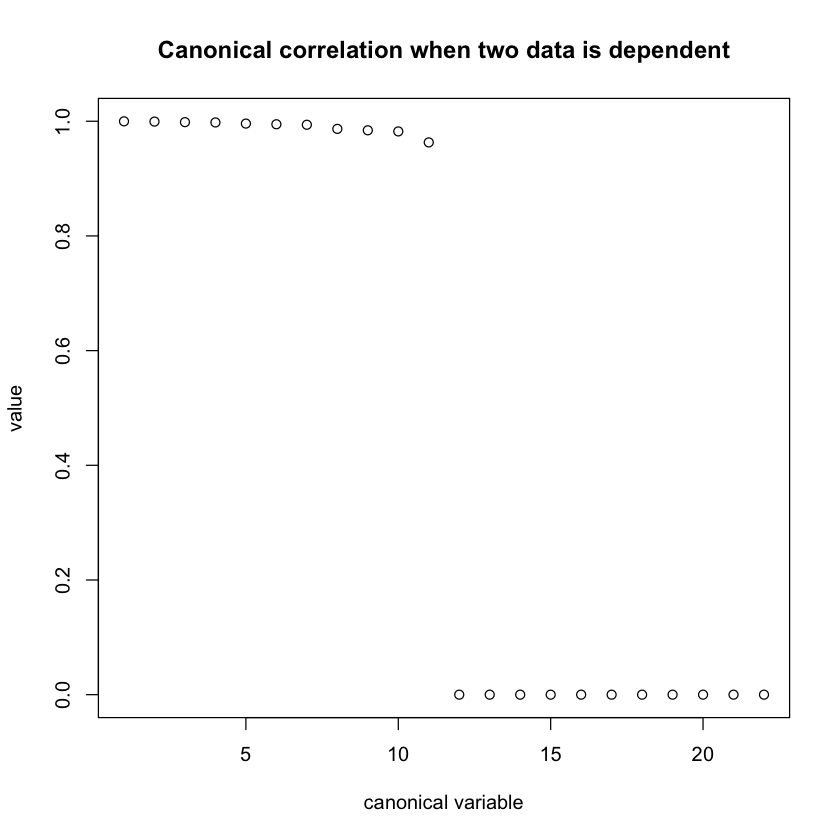

In [76]:




data <- synth.data_from_graph(n, p, cov, basis.m_list, Apinv_list, N_list, dependent=TRUE, addnoise=FALSE)
##compute mean of the data across p
data_mean <- utility.mean_data(data) # n \times p
##compute functional basis of each modality


km.est <- km.gen
#for(i in 1:length(km.est)){
    
#    if(km.est[i]  > k.gen){
#        km.est[i] <- k.gen
#    }
#}

k.est <- min(km.est)

fbasis_list <- list()
for(m in 1:M){
    print(paste("Esimtating funcational basis of data modality",m))
    fbasis_list[[m]] <- estimate.fpca.basis(c(0,1), obs.time, t(data_mean[[m]]), km.est[m], bs.nbasis=km.est[m]*2)$vectors
}
#data modality 1
bspline.basis1 <- create.bspline.basis(rangeval=c(0,1), nbasis=2*km.est[1])
d1 <-Data2fd(argvals=obs.time, y=t(data_mean[[1]]), basisobj=bspline.basis1)
#data modality 2
bspline.basis2 <- create.bspline.basis(rangeval=c(0,1), nbasis=2*km.est[2])
d2 <-Data2fd(argvals=obs.time, y=t(data_mean[[2]]), basisobj=bspline.basis2)

ccoar <- cca.fd(d1, d2)$ccacorr
print(ccoar)
par(bg="white")
plot(ccoar,xlab="canonical variable", ylab="value",main="Canonical correlation when two data is dependent")

 [1] 9.75027275 2.75281623 1.08994075 0.65213487 0.36735540 0.28348321
 [7] 0.21105804 0.12395177 0.09801601 0.08934667 0.05851968
 [1] 9.68127207 2.78363043 1.06811753 0.63441097 0.37324640 0.26966069
 [7] 0.21559247 0.11339937 0.09960167 0.09108534 0.05958075
[1] "cca correlation"
 [1] 1.1048840 0.9994166 0.9991326 0.9979574 0.9958773 0.9949974 0.9945385
 [8] 0.9881595 0.9850308 0.9833161 0.9704913


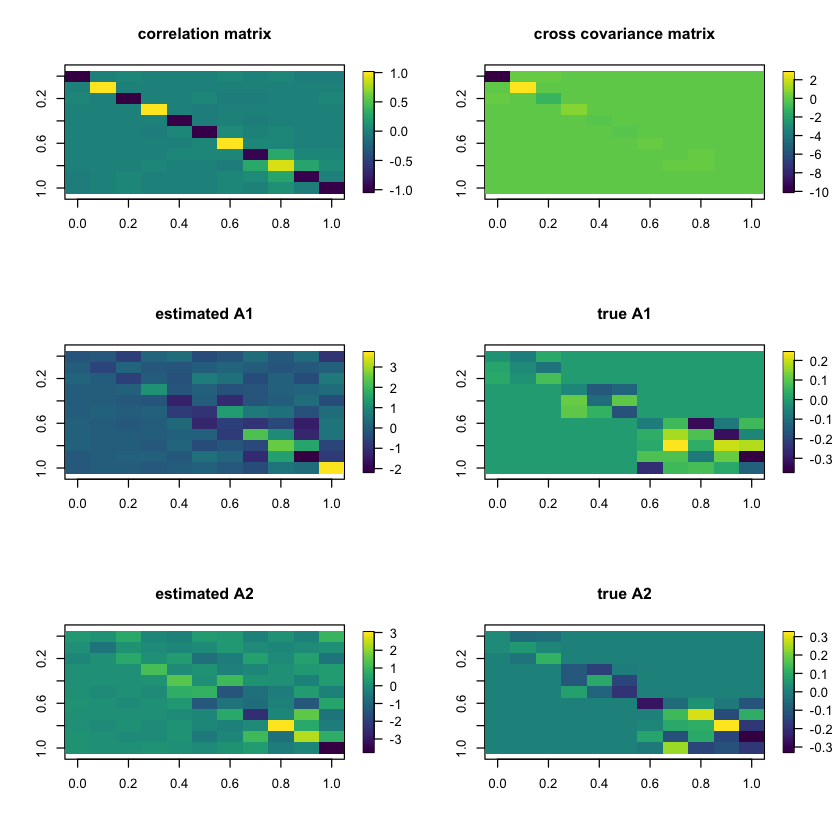

In [77]:
fbasis_list <- list()
fvalue_list <- list()
for(m in 1:M){
    #adjust number of basis to estimate
    temp_values <- estimate.fpca.basis(c(0,1), obs.time, t(data_mean[[m]]), km.est[m], bs.nbasis=km.est[m]*2)$values
    #print(paste("Number of km before adjustment", km.est[m]))
    km.est[m]<-length(which(temp_values>1e-8))
    #print(paste("Number of km after adjustment", km.est[m]))

    fbasis_list[[m]] <- estimate.fpca.basis(c(0,1), obs.time, t(data_mean[[m]]), km.est[m], bs.nbasis=km.est[m]*2)$vectors
    
    fvalue_list[[m]] <- estimate.fpca.basis(c(0,1), obs.time, t(data_mean[[m]]), km.est[m], bs.nbasis=km.est[m]*2)$values[1:km.est[m]]
    print(fvalue_list[[m]])
    #par(bg="white")
    #plot(fbasis_list[[m]])
}


k.est <- min(km.est)

cca.r.m<- estimate.cca.matrix(d1,d2,  fbasis_list[[1]],  fbasis_list[[2]], fvalue_list[[1]], fvalue_list[[2]], ncan=k.est)
cov.r.m <- cross.cov(d1,d2,  fbasis_list[[1]],  fbasis_list[[2]], fvalue_list[[1]], fvalue_list[[2]], ncan=k.est)
par(bg="white", mfrow=c(3,2))
image.plot(cca.r.m, col=viridis(64),ylim=c(1.1,-0.1), main="correlation matrix")

image.plot(cov.r.m, col=viridis(64),ylim=c(1.1,-0.1), main="cross covariance matrix")
#print(A_list[[1]] %*% Apinv_list[[1]])


cca.r.est <- estimate.cca(d1,d2,  fbasis_list[[1]],  fbasis_list[[2]], fvalue_list[[1]], fvalue_list[[2]], ncan=k.est)
print("cca correlation")
print(cca.r.est$corr)

max_val = max(cca.r.est$A1, A_list[[1]]) + 1
min_val = min(cca.r.est$A1, A_list[[1]]) - 1
lim = max(max_val,abs(min_val))

image.plot(cca.r.est$A1, col=viridis(64), ylim=c(1.1,-0.1),main="estimated A1")
image.plot(A_list[[1]], col=viridis(64), ylim=c(1.1,-0.1),   main="true A1")


max_val = max(cca.r.est$A2, A_list[[2]]) + 1
min_val = min(cca.r.est$A2, A_list[[2]]) - 1
lim = max(max_val,abs(min_val))
#image.plot(cca.r.true$A2, col=viridis(64))
image.plot(cca.r.est$A2, col=viridis(64), ylim=c(1.1,-0.1), main="estimated A2")
image.plot(A_list[[2]], col=viridis(64), ylim=c(1.1,-0.1),  main="true A2")


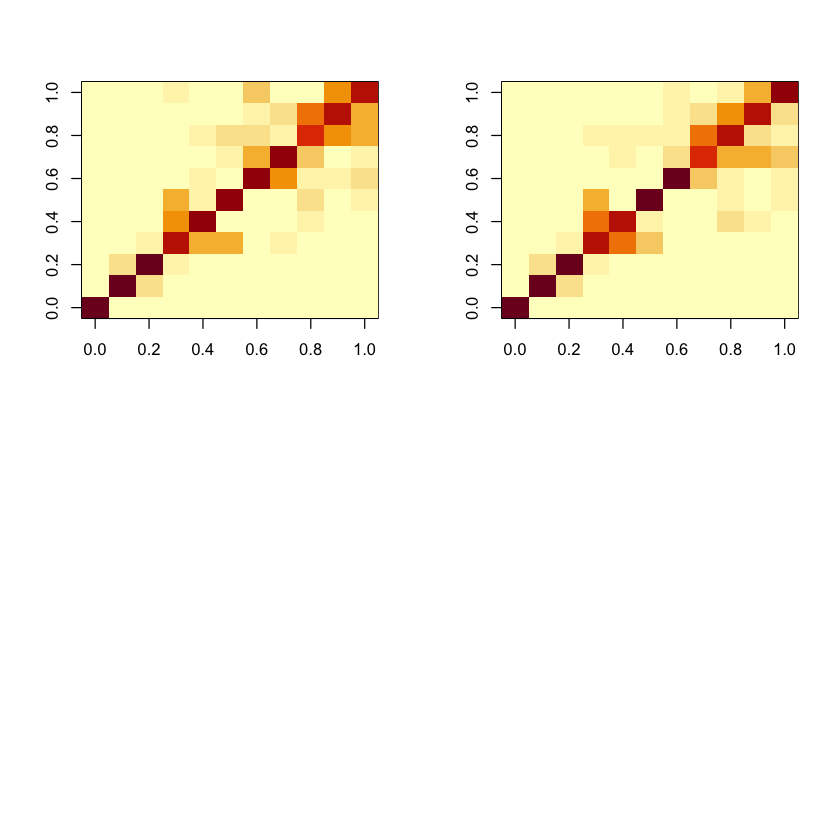

In [30]:

par(bg="white", mfrow=c(2,2))
for(m in 1:M){
    image(abs(inprod(true.basis_list[[m]], fbasis_list[[m]])))
    
}
#